#**Libraries used**

In [ ]:
!pip uninstall pandas-profiling

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install kneed
!pip install susi
!pip install onedrivedownloader

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
"""Importing all the libraries we need for handling data, visualization and training our SOM model."""
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns

import sklearn as skl

# We used to convert categorical data into numerical labels
from sklearn.preprocessing import LabelEncoder

import pandas_profiling
from pandas_profiling import ProfileReport

import IPython

import susi
import matplotlib.pyplot as plt

import itertools

# Graphs
import plotly.graph_objects as go
import plotly.express as px

# Kmeans algorithm
from sklearn.cluster import KMeans
# Siluhete score
from sklearn.metrics import silhouette_score
# View number of clusters
from kneed import KneeLocator
# Download stuff from Onedrive
from onedrivedownloader import download


from collections import defaultdict

#**Step 1** - Environment preparation


In [ ]:
# Load the dataset

# url_train = "https://1drv.ms/x/c/dc7ea6a5fa854151/ESOukJIZuAVPt143Q-Z6W78BtFMuA492AFo08ahCB5LiNA?e=enF8xX"
# url_test = "https://1drv.ms/x/c/dc7ea6a5fa854151/EZbg7B4_g_RHrf60j6N7CIYBCJ4QIHZrp6HFaDFPtFAmqQ?e=J67FXh"
# download(url_train, filename="train.csv")
# download(url_test, filename="test.csv")
# train_dataset = pd.read_csv("train.csv", header = 0)
# test_dataset = pd.read_csv("test.csv", header = 0)

train_dataset = pd.read_csv("pokemon_train_dataset.csv")
test_dataset = pd.read_csv("pokemon_test_dataset.csv")


In [ ]:
print(train_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   against_bug       796 non-null    float64
 1   against_dark      796 non-null    float64
 2   against_dragon    796 non-null    float64
 3   against_electric  796 non-null    float64
 4   against_fairy     796 non-null    float64
 5   against_fight     796 non-null    float64
 6   against_fire      796 non-null    float64
 7   against_flying    796 non-null    float64
 8   against_ghost     796 non-null    float64
 9   against_grass     796 non-null    float64
 10  against_ground    796 non-null    float64
 11  against_ice       796 non-null    float64
 12  against_normal    796 non-null    float64
 13  against_poison    796 non-null    float64
 14  against_psychic   796 non-null    float64
 15  against_rock      796 non-null    float64
 16  against_steel     796 non-null    float64
 1

In [ ]:
# We drop the columns that we don't need for training Before doing this, we make a copy of the dataset to keep all attributes for later use.
pokemon_labels_train = train_dataset.copy()
train_dataset = train_dataset.drop(columns=['name', 'pokedex_number', 'generation', 'against_normal', 'type1', 'type2'])

pokemon_labels_test = test_dataset.copy()
test_dataset = test_dataset.drop(columns=["name", "pokedex_number", "generation", 'against_normal', 'type1', 'type2'])

In [ ]:
print(train_dataset.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   against_bug       796 non-null    float64
 1   against_dark      796 non-null    float64
 2   against_dragon    796 non-null    float64
 3   against_electric  796 non-null    float64
 4   against_fairy     796 non-null    float64
 5   against_fight     796 non-null    float64
 6   against_fire      796 non-null    float64
 7   against_flying    796 non-null    float64
 8   against_ghost     796 non-null    float64
 9   against_grass     796 non-null    float64
 10  against_ground    796 non-null    float64
 11  against_ice       796 non-null    float64
 12  against_poison    796 non-null    float64
 13  against_psychic   796 non-null    float64
 14  against_rock      796 non-null    float64
 15  against_steel     796 non-null    float64
 16  against_water     796 non-null    float64
 1

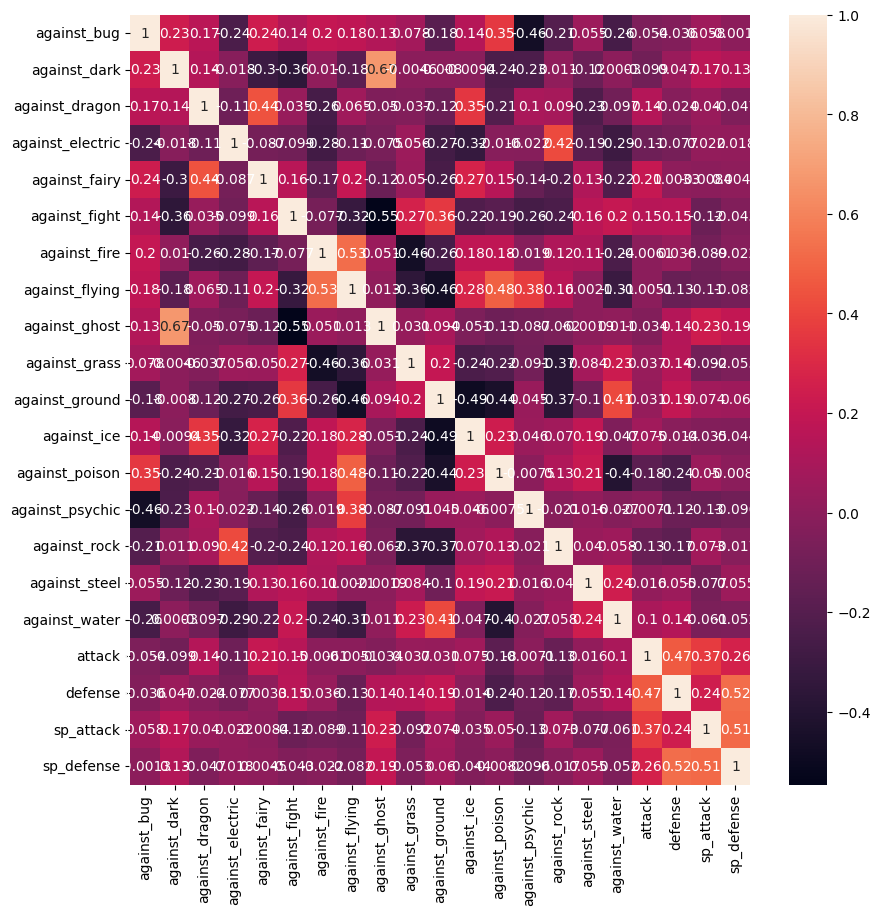

In [ ]:
corr_matrix = train_dataset.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
"""
We created a box plot to check for outliers in the dataset.
Reference: https://plotly.com/python/plotly-express/
"""

df_join = pd.melt(train_dataset)

# Box plot for all columns
fig = px.box(df_join, x="variable", y="value", title="Box Plot of Pokemon Stats")
fig.show()


#**Step 2** - Implementation

##Functions

In [ ]:
"""
Finds the Best Matching Unit (BMU) in the SOM by calculating the Euclidean
distance between the input and all neurons. Returns the BMU's weight vector
and its position in the grid.
"""

def cal_bmu(input_pat, w_matrix, map_side):
  distances = np.sqrt(((w_matrix - input_pat) ** 2).sum(axis=2))

  bmu_flat_idx = np.argmin(distances)

  bmu_idx = np.unravel_index(bmu_flat_idx, (map_side, map_side))
  bmu = w_matrix[bmu_idx]
  return (bmu, bmu_idx)

In [ ]:
""" Slowly reduces the learning rate over time. """
def learning_rate_variation(
    initial_lr,
    i,
    epochs):
    return initial_lr * np.exp(-i / epochs)

In [ ]:
""" Same as learning rate, it gradually reduces the neighborhood size during training. """
def neighborhood_variation(neighborhood, i, epochs):
    sigma = 0.6
    t = i / epochs
    return neighborhood * (1 - (t / sigma)**2) * np.exp(-t**2 / (2 * sigma**2)) + 1

In [ ]:
""" This calculates how much a neuron is influenced by the BMU based on its distance. """
def calculate_bmu_influence(
    distance_to_bmu,
    current_neighborhood):
  return np.exp(-distance_to_bmu ** 2 / (2 * (current_neighborhood ** 2)))

In [ ]:
def paint_map(weight_matrix, epochs):
    feature_map = weight_matrix.mean(axis=2)
    fig = px.imshow(feature_map, origin='lower', color_continuous_scale="turbo")
    fig.update_layout(title=f'SOM Model after {epochs} epochs', xaxis_title='X', yaxis_title='Y')
    fig.show()


In [ ]:
""" This calculates the average quantization error, measuring how well inputs match their BMUs. """
def quantization_error(
    model,
    input_data,
    map_side):
    distances = [cal_bmu(data_point, model, map_side)[0] for data_point in input_data]

    return np.mean(distances)

In [ ]:
""" This function finds the first and second BMUs for an input and calculates the topographic error. """
def calculate_first_second_bmu(
    model,
    input_vector,
    map_side
):

    distances = np.linalg.norm(model - input_vector, axis=2)
    distances = distances.reshape(-1)

    first_bmu_index = np.argmin(distances)
    bmu_idx = np.unravel_index(first_bmu_index, (map_side, map_side))
    first_bmu_distance = distances[first_bmu_index]
    first_bmu_weights = model[bmu_idx]

    distances[first_bmu_index] = np.inf

    second_bmu_index = np.argmin(distances)
    bmu_idx2 = np.unravel_index(second_bmu_index, (map_side, map_side))
    second_bmu_distance = distances[second_bmu_index]
    second_bmu_weights = model[bmu_idx2]

    return first_bmu_index, first_bmu_distance, first_bmu_weights, second_bmu_index, second_bmu_distance, second_bmu_weights

""" Calculates the topographic error, checking if the first and second BMUs are close. """
def topographic_error(
    model,
    input_data,
    map_side,
    threshold = 0.2):

    count = sum(
        np.linalg.norm(np.array(coord1) - np.array(coord2)) > threshold
        for input_vector in input_data
        for _, _, coord1, _, _, coord2 in [calculate_first_second_bmu(model, input_vector, map_side)]
    )

    return count / len(input_data)

In [ ]:
for column in train_dataset.columns:
    print(f"Column: {column}")
    print(f" - Data type: {train_dataset[column].dtype}")
    print(f" - Non-null values: {train_dataset[column].count()}")


Column: against_bug
 - Data type: float64
 - Non-null values: 796
Column: against_dark
 - Data type: float64
 - Non-null values: 796
Column: against_dragon
 - Data type: float64
 - Non-null values: 796
Column: against_electric
 - Data type: float64
 - Non-null values: 796
Column: against_fairy
 - Data type: float64
 - Non-null values: 796
Column: against_fight
 - Data type: float64
 - Non-null values: 796
Column: against_fire
 - Data type: float64
 - Non-null values: 796
Column: against_flying
 - Data type: float64
 - Non-null values: 796
Column: against_ghost
 - Data type: float64
 - Non-null values: 796
Column: against_grass
 - Data type: float64
 - Non-null values: 796
Column: against_ground
 - Data type: float64
 - Non-null values: 796
Column: against_ice
 - Data type: float64
 - Non-null values: 796
Column: against_poison
 - Data type: float64
 - Non-null values: 796
Column: against_psychic
 - Data type: float64
 - Non-null values: 796
Column: against_rock
 - Data type: float64
 -

In [ ]:
""" This function is the train function. It has the print map included so once the best hyperparameters are chosen this function is called and trains the SOM. """
def train_with_print(training_data, weight_matrix, lr, neighborhood, epochs, output_index, map_side, paint=True):
    for epoch in range(1, epochs + 1):
        input_sample = training_data[np.random.randint(0, len(training_data) - 1)]
        learning_rate = learning_rate_variation(lr, epoch, epochs)
        neighborhood = neighborhood_variation(neighborhood, epoch, epochs)
        bmu, bmu_idx = cal_bmu(input_sample, weight_matrix, map_side)
        x, y = output_index
        distance_to_bmu = np.sqrt((x - bmu_idx[0]) ** 2 + (y - bmu_idx[1]) ** 2)
        bmu_influence = calculate_bmu_influence(distance_to_bmu, neighborhood)
        weight_matrix += learning_rate * bmu_influence[..., np.newaxis] * (input_sample - weight_matrix)
        if paint and (epoch % 5000 == 0):
            paint_map(weight_matrix, epoch)
    return weight_matrix

In [ ]:
"""  We used it to test different hyperparameters quickly."""
def train(training_data, weight_matrix, lr, neighborhood, epochs, output_index, map_side, paint=False):
    for epoch in range(1, epochs + 1):
        input_sample = training_data[np.random.randint(0, len(training_data) - 1)]
        learning_rate = learning_rate_variation(lr, epoch, epochs)
        neighborhood = neighborhood_variation(neighborhood, epoch, epochs)
        bmu, bmu_idx = cal_bmu(input_sample, weight_matrix, map_side)
        x, y = output_index
        distance_to_bmu = np.sqrt((x - bmu_idx[0]) ** 2 + (y - bmu_idx[1]) ** 2)
        bmu_influence = calculate_bmu_influence(distance_to_bmu, neighborhood)
        weight_matrix += learning_rate * bmu_influence[..., np.newaxis] * (input_sample - weight_matrix)
        if paint and(epoch == epochs or epoch == 1):
            paint_map(weight_matrix, epoch)

    return weight_matrix

In [ ]:
print("Max value in train dataset:", train_dataset.max().max())
print("Min value in train dataset:", train_dataset.min().min())

Max value in train dataset: 230.0
Min value in train dataset: 0.0


In [ ]:
"""
We prepare the data and initialize the weight matrix.
Then we normalize the dataset and extract a smaller weight matrix based on map size.
"""
max_map_side = 35
initial_weight_matrix_large = None

def process_data_and_initialize_weights(initial_data, map_side, normalize_data=True):
    global initial_weight_matrix_large

    num_examples = initial_data.shape[0]
    num_features = initial_data.shape[1]

    initial_sigma = map_side / 2

    if normalize_data:
        data_min = initial_data.min(axis=0)  # minimum value for each feature
        data_max = initial_data.max(axis=0)  # maximum value for each feature
        normalized_data = (initial_data - data_min) / (data_max - data_min + 1e-8)  # Here we avoid division by zero
    else:
        normalized_data = initial_data

    if initial_weight_matrix_large is None:
        initial_weight_matrix_large = np.random.rand(max_map_side, max_map_side, num_features)

    initial_weight_matrix = initial_weight_matrix_large[:map_side, :map_side, :]
    output_index = np.indices((map_side, map_side))

    return normalized_data, initial_weight_matrix, output_index, initial_sigma

In [ ]:
"""
Here we test different combinations of hyperparameters to find the best one.
And we train the model for each set of parameters and calculate the errors.
"""
def search_parameters(initial_data, map_side_range, epochs_range, initial_lr_range):
    results = []

    for map_side in map_side_range:
        for epochs in epochs_range:
            for initial_lr in initial_lr_range:
                normalize_data, initial_weight_matrix, output_index, initial_sigma = process_data_and_initialize_weights(initial_data, map_side)

                model_w_matrix = train(normalize_data, initial_weight_matrix, initial_lr, initial_sigma, epochs, output_index, map_side)
                quantization_err = quantization_error(model_w_matrix, normalize_data, map_side)
                topographic_err = topographic_error(model_w_matrix, normalize_data, map_side)
                results.append({
                    "map_side": map_side,
                    "epochs": epochs,
                    "initial_lr": initial_lr,
                    "quantization_error": quantization_err,
                    "topographic_error": topographic_err
                })

                print(f"Hyperparameters: map_side={map_side}, epochs={epochs}, initial_lr={initial_lr}")
                print(f"Quantization Error: {quantization_err:.4f}")
                print(f"Topographic Error: {topographic_err:.4f}")
                print("-" * 20)
    return pd.DataFrame(results)

##Specifying hyperparameters

In [ ]:
"""
In this part we define the hyperparameter ranges and find the best combination.
We test different map sizes, epochs, and learning rates, then selects the best.
"""
map_side_range = list(range(15,36, 2))
epochs_range = [60000, 70000, 80000, 90000]
initial_lr_range = [0.05, 0.1, 0.15, 0.2]


initial_data = train_dataset.to_numpy()

results_df = search_parameters(initial_data, map_side_range, epochs_range, initial_lr_range)

results_df['combined_error'] = results_df['quantization_error'] + results_df['topographic_error']

best_results = results_df.sort_values(by=['combined_error']).head(1)

print(best_results[['map_side', 'epochs', 'initial_lr', 'combined_error']])

# Then we save the best values to then use them
best_map_side = int(best_results['map_side'].values[0])
best_epochs = int(best_results['epochs'].values[0])
best_initial_lr = float(best_results['initial_lr'].values[0])

Hyperparameters: map_side=15, epochs=60000, initial_lr=0.05
Quantization Error: 0.2653
Topographic Error: 0.4598
--------------------
Hyperparameters: map_side=15, epochs=60000, initial_lr=0.1
Quantization Error: 0.2646
Topographic Error: 0.4472
--------------------
Hyperparameters: map_side=15, epochs=60000, initial_lr=0.15
Quantization Error: 0.2655
Topographic Error: 0.4824
--------------------
Hyperparameters: map_side=15, epochs=60000, initial_lr=0.2
Quantization Error: 0.2652
Topographic Error: 0.4912
--------------------
Hyperparameters: map_side=15, epochs=70000, initial_lr=0.05
Quantization Error: 0.2654
Topographic Error: 0.4598
--------------------
Hyperparameters: map_side=15, epochs=70000, initial_lr=0.1
Quantization Error: 0.2651
Topographic Error: 0.4598
--------------------
Hyperparameters: map_side=15, epochs=70000, initial_lr=0.15
Quantization Error: 0.2651
Topographic Error: 0.4598
--------------------
Hyperparameters: map_side=15, epochs=70000, initial_lr=0.2
Quanti

In [ ]:
"""
We used a parallel coordinates plot to visualize hyperparameter results.
Reference: https://plotly.com/python/plotly-express/
"""

fig = px.parallel_coordinates(
    results_df,
    color="combined_error",
    dimensions=["map_side", "epochs", "initial_lr", "combined_error"],
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="Parallel Coordinates Plot of Hyperparameter Optimization"
)
fig.show()

In [ ]:
""" We used the best hyperparameters to train the final SOM."""
map_side = best_map_side
epochs = best_epochs
initial_lr = best_initial_lr

best_initial_weight_matrix = initial_weight_matrix_large[:best_map_side, :best_map_side, :]
initial_data= train_dataset.to_numpy()

In [ ]:
normalize_data, initial_weight_matrix, output_index, initial_sigma = process_data_and_initialize_weights(initial_data, map_side)

In [ ]:
# Create dataset summary (assuming df_normalized is a previously created DataFrame)
summary = pd.DataFrame(columns=['Variable', 'Data Type', 'Range / Unique Values', 'Example Value', 'Non-null Count'])

for col in df_normalized.columns:
    dtype = df_normalized[col].dtype
    non_null_count = df_normalized[col].count()
    example = df_normalized[col].dropna().iloc[0] if non_null_count > 0 else None

    if pd.api.types.is_numeric_dtype(df_normalized[col]):
        min_val = df_normalized[col].min()
        max_val = df_normalized[col].max()
        value_range = f"{min_val:.3f} - {max_val:.3f}"
    else:
        unique_vals = df_normalized[col].nunique()
        value_range = f"{unique_vals} unique values"

    summary = pd.concat([summary, pd.DataFrame({
        'Variable': [col],
        'Data Type': [dtype],
        'Range / Unique Values': [value_range],
        'Example Value': [example],
        'Non-null Count': [non_null_count]
    })], ignore_index=True)

# Display summary table
print(summary)

In [ ]:
model_w_matrix = train_with_print(normalize_data, best_initial_weight_matrix, best_initial_lr, initial_sigma, best_epochs, output_index, best_map_side)

##Generalization degree

In [ ]:
""" In this function, we find the Best Matching Unit (BMU) for each data point."""
def calculate_bmu_indices(normalized_data, weight_matrix, map_side):
    bmu_indices = []
    for pokemon_data in normalized_data:
        _, bmu_idx = cal_bmu(pokemon_data, weight_matrix, map_side)
        bmu_indices.append(bmu_idx)
    return bmu_indices

In [ ]:
""" This function maps each Pokemon to its Best Matching Unit (BMU) location."""
def create_pokemon_locations(pokemon_names, bmu_indices):
    pokemon_locations = {}
    for i, pokemon_name in enumerate(pokemon_names):
        pokemon_locations[pokemon_name] = bmu_indices[i]
    return pokemon_locations

In [ ]:
""" Here we display the positions of the test Pokemon's on the SOM map. """
def position_pokemons_som(pokemon_locations_test, model_w_matrix):
    plt.figure(figsize=(10, 10))
    plt.title('Test Pokemon Locations on the SOM')
    plt.xlabel('X Dimension of SOM')
    plt.ylabel('Y Dimension of SOM')

    plt.imshow(model_w_matrix.mean(axis=2), origin="lower", cmap="viridis", extent=[0, model_w_matrix.shape[1], 0, model_w_matrix.shape[0]])

    for i, (pokemon_index, loc) in enumerate(pokemon_locations.items()):
        plt.scatter(loc[1], loc[0], color="red", s=20, alpha=0.7)  # Each point is a Pokémon in the TRAIN

    for pokemon_index, loc in pokemon_locations_test.items():
        plt.scatter(loc[1], loc[0], color="black", s=20, alpha=0.7)  # Each point is a test Pokémon
        plt.text(loc[1] + 0.5, loc[0] + 0.5, pokemon_index, color="black", fontsize=8)

    plt.show()

In [ ]:
"""
Here we find the closest Pokemon to each test Pokemon on the SOM.
We check which training Pokemon are within a distance of 1 and
print their type and generation to analyze the clustering.
"""
def find_neighborhood(pokemon_locations_train, pokemon_locations_test, weight_matrix, pokemon_labels_train, pokemon_labels_test):

    for test_pokemon, test_loc in pokemon_locations_test.items():
        test_pokemon_data = pokemon_labels_test[pokemon_labels_test['name'] == test_pokemon][[

    "type1", "type2"
]].iloc[0]
        test_pokemon_values = test_pokemon_data.values
        print(f"Test Pokemon: {test_pokemon}: {test_pokemon_values}")

        neighborhood_pokemon = []
        for train_pokemon, train_loc in pokemon_locations_train.items():
            if np.linalg.norm(np.array(test_loc) - np.array(train_loc)) <= 1:
                neighborhood_pokemon.append(train_pokemon)

        print("Neighborhood Pokemon:")
        for pokemon in neighborhood_pokemon:
            pokemon_data = pokemon_labels_train[pokemon_labels_train['name'] == pokemon][[

    "type1", "type2"
]].iloc[0]

            pokemon_values = pokemon_data.values
            print(f"- {pokemon}: {pokemon_values}")
        print("-" * 20)

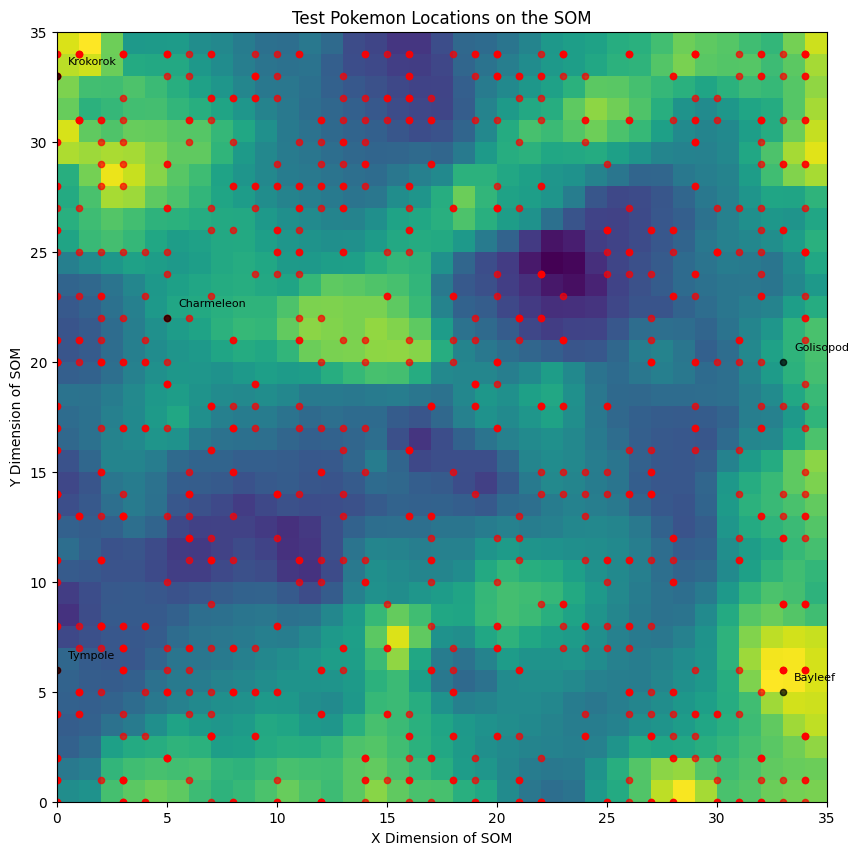

Test Pokemon: Charmeleon: ['fire' nan]
Neighborhood Pokemon:
- Victini: ['psychic' 'fire']
- Chandelure: ['ghost' 'fire']
- Delphox: ['fire' 'psychic']
--------------------
Test Pokemon: Bayleef: ['grass' nan]
Neighborhood Pokemon:
- Parasect: ['bug' 'grass']
- Wormadam: ['bug' 'grass']
- Abomasnow: ['grass' 'ice']
- Leavanny: ['bug' 'grass']
--------------------
Test Pokemon: Tympole: ['water' nan]
Neighborhood Pokemon:
- Slowpoke: ['water' 'psychic']
--------------------
Test Pokemon: Krokorok: ['ground' 'dark']
Neighborhood Pokemon:
- Geodude: ['rock' 'ground']
- Graveler: ['rock' 'ground']
- Onix: ['rock' 'ground']
- Rhyhorn: ['ground' 'rock']
- Larvitar: ['rock' 'ground']
- Pupitar: ['rock' 'ground']
--------------------
Test Pokemon: Golisopod: ['bug' 'water']
Neighborhood Pokemon:
- Gyarados: ['water' 'flying']
--------------------


In [ ]:
"""
Here we normalize the data, find BMU positions, and map Pokemon locations on the SOM.
Then, we visualize the SOM and check nearby training Pokemon for each test Pokemon.
"""
test_data_normalized, _, _, _ = process_data_and_initialize_weights(test_dataset.values, model_w_matrix.shape[0], normalize_data=True)
bmu_indices_test = calculate_bmu_indices(test_data_normalized, model_w_matrix, best_map_side)

pokemon_names_test = pokemon_labels_test["name"]
pokemon_names_train = pokemon_labels_train["name"]

train_data_normalized, _, _, _ = process_data_and_initialize_weights(train_dataset.values, model_w_matrix.shape[0], normalize_data=True)
bmu_indices_train = calculate_bmu_indices(train_data_normalized, model_w_matrix, best_map_side)
pokemon_locations = create_pokemon_locations(pokemon_names_train, bmu_indices_train)

# We calculate the position in the SOM map and print the map with the possition of the TRAIN Pokemons.
pokemon_locations_test = create_pokemon_locations(pokemon_names_test, bmu_indices_test)
position_pokemons_som(pokemon_locations_test, model_w_matrix)

# Now that we have the location for the TRAIN and TEST dataset, this function prints the TRAIN pokemons in the neighborhood of the TEST pokemons.
find_neighborhood(pokemon_locations, pokemon_locations_test, model_w_matrix, pokemon_labels_train, pokemon_labels_test)

# **Step 3** - Evaluation

##Number of clusters

In [ ]:
"""
Here we use K-Means to find the optimal number of clusters in the SOM.
We calculate WCSS and silhouette scores for different values of k.
"""
k_values = range(2, 100)

models = []
WCSS = []
silhouette_scores = []


for k in k_values:

    model = KMeans(
        n_clusters = k,
        random_state = 1234567,
        max_iter = 30,
        n_init = 'auto')

    models.append(model)

    reshaped_weights = model_w_matrix.reshape(-1, model_w_matrix.shape[-1])
    y_pred = model.fit_predict(reshaped_weights)

    WCSS.append(model.inertia_)

    best_initial_weight_matrix = initial_weight_matrix_large[:best_map_side, :best_map_side, :]
    initial_reshaped_weights = best_initial_weight_matrix.reshape(-1, best_initial_weight_matrix.shape[-1])

    silhouette_scores.append(
        silhouette_score(
            initial_reshaped_weights,
            model.labels_,
            metric='euclidean'))

<ipython-input-140-857e9ad3e852>:12: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



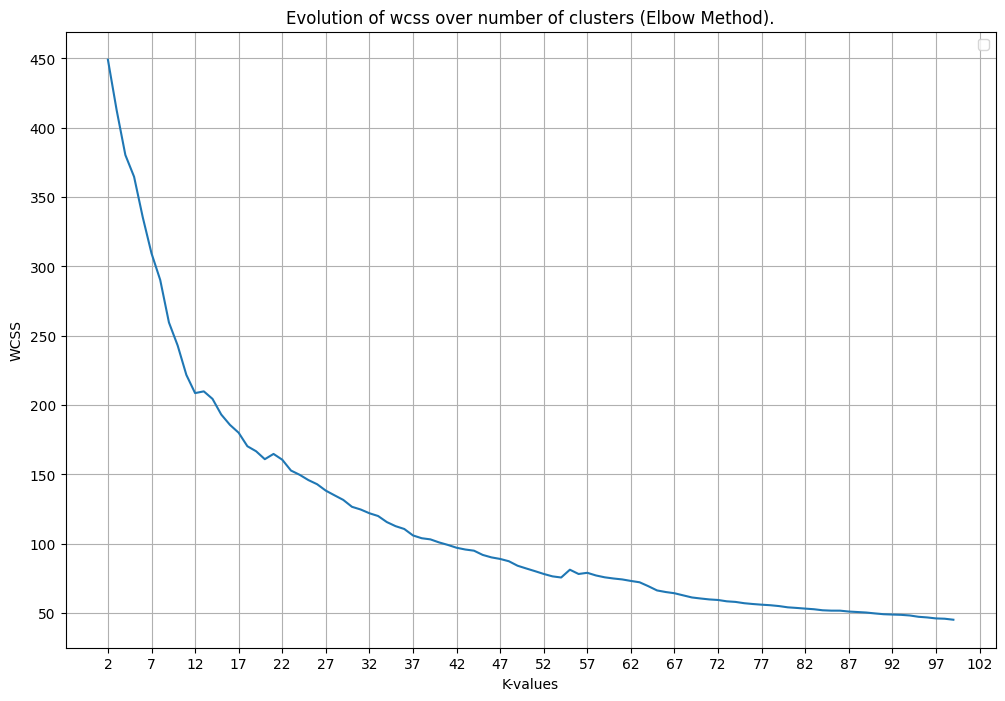

In [ ]:
"""
Here we use the Elbow Method to determine the optimal number of clusters.
We plot WCSS to see where the curve starts to flatten.
"""

plt.figure(figsize=(12, 8))

sns.lineplot(
    x = k_values,
    y = WCSS)

plt.legend()
plt.title('Evolution of wcss over number of clusters (Elbow Method).')
plt.xlabel('K-values')
plt.ylabel('WCSS')
plt.grid(True)
plt.xticks(np.arange(min(k_values), max(k_values)+5, 5))

plt.show()

In [ ]:
""" Here we find the optimal number of clusters using KneeLocator."""
knee = KneeLocator(k_values, WCSS, curve='convex', direction='decreasing')
optimal_k = knee.elbow

print(f"The optimal number of clusters (k) is: {optimal_k}")

The optimal number of clusters (k) is: 12


In [ ]:
"""Here we appply K-Means clustering to the SOM weight matrix and visualize the clusters."""

def paint_map_clusters(weight_matrix, epochs, i, n_clusters):
    weight_matrix = np.array(weight_matrix)

    map_shape = weight_matrix.shape[:2]
    reshaped_weights = weight_matrix.reshape(-1, weight_matrix.shape[-1])
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(reshaped_weights)
    cluster_map = cluster_labels.reshape(map_shape)

    fig = px.imshow(cluster_map, origin='lower', color_continuous_scale="turbo")
    fig.update_layout(title=f'SOM Clustering - Model {i} - {epochs} epochs', xaxis_title='X', yaxis_title='Y')
    fig.show()

    cluster_centers = kmeans.cluster_centers_

     # We get the most important features for each cluster
    top_features = np.argsort(cluster_centers, axis=1)[:, -2:]

    df_clusters = pd.DataFrame({
        "Cluster": np.arange(n_clusters),
        "Feature":  top_features[:, 1],
        "Feature 1": [train_dataset.columns[i] for i in top_features[:, 1]],
        "Feature 2": [train_dataset.columns[i] for i in top_features[:, 0]]
    })
    df_clusters['Features'] = df_clusters['Feature 1'] + ' y ' + df_clusters['Feature 2']
    fig_bar = px.bar(df_clusters, x="Cluster", y="Feature",
                     title="Top Two Features per Cluster",
                     labels={"Feature": "Most Important Feature"},
                     text="Features")
    fig_bar.show()

    return cluster_labels, top_features

In [ ]:
result = paint_map_clusters(model_w_matrix, epochs, 0, optimal_k)

##Classification map

In [ ]:
original_train_dataset = pd.read_csv("pokemon_train_dataset.csv", header=0)
pokemon_names = original_train_dataset["name"]

In [ ]:
"""
Here we visualize the classification map by grouping Pokemon's into clusters.
We apply KMeans to the SOM to identify clusters and display Pokemon's names on the map.
"""

def visualize_map_pokemons_neuron(weight_matrix, pokemon_locations, num_clusters):

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(weight_matrix.reshape(-1, weight_matrix.shape[-1]))
    cluster_labels = cluster_labels.reshape(weight_matrix.shape[:2])
    cmap = plt.get_cmap('viridis', num_clusters)
    fig, ax = plt.subplots(figsize=(20, 20))

    ax.imshow(cluster_labels, cmap=cmap, origin='lower')

    cluster_pokemon = defaultdict(list)
    for pokemon_name, loc in pokemon_locations.items():
        cluster_id = cluster_labels[loc[0], loc[1]]
        cluster_pokemon[cluster_id].append(pokemon_name)

    for cluster_id, pokemon_names in cluster_pokemon.items():
        cluster_indices = np.where(cluster_labels == cluster_id)
        center_x = np.mean(cluster_indices[1])
        center_y = np.mean(cluster_indices[0])

        text = "\n".join(pokemon_names)
        bbox_props = dict(boxstyle="round", facecolor="white", alpha=0.8)
        ax.text(center_x, center_y, text, ha="center", va="center", bbox=bbox_props, fontsize=6)

    ax.set_title('Classification map')
    ax.set_xlabel('X Dimension of SOM')
    ax.set_ylabel('Y Dimension of SOM')

    plt.show()

In [ ]:
"""Print the cluster number and the names of the Pokémon horizontally."""

def print_pokemons_cluster(weight_matrix, pokemon_locations, num_clusters):

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(weight_matrix.reshape(-1, weight_matrix.shape[-1]))
    cluster_labels = cluster_labels.reshape(weight_matrix.shape[:2])

    cluster_pokemon = defaultdict(list)
    for pokemon_name, loc in pokemon_locations.items():
        cluster_id = cluster_labels[loc[0], loc[1]]
        cluster_pokemon[cluster_id].append(pokemon_name)

    sorted_clusters = sorted(cluster_pokemon.items())

    for cluster_id, pokemon_names in sorted_clusters:
        print(f"Cluster {cluster_id}: {', '.join(pokemon_names)}")

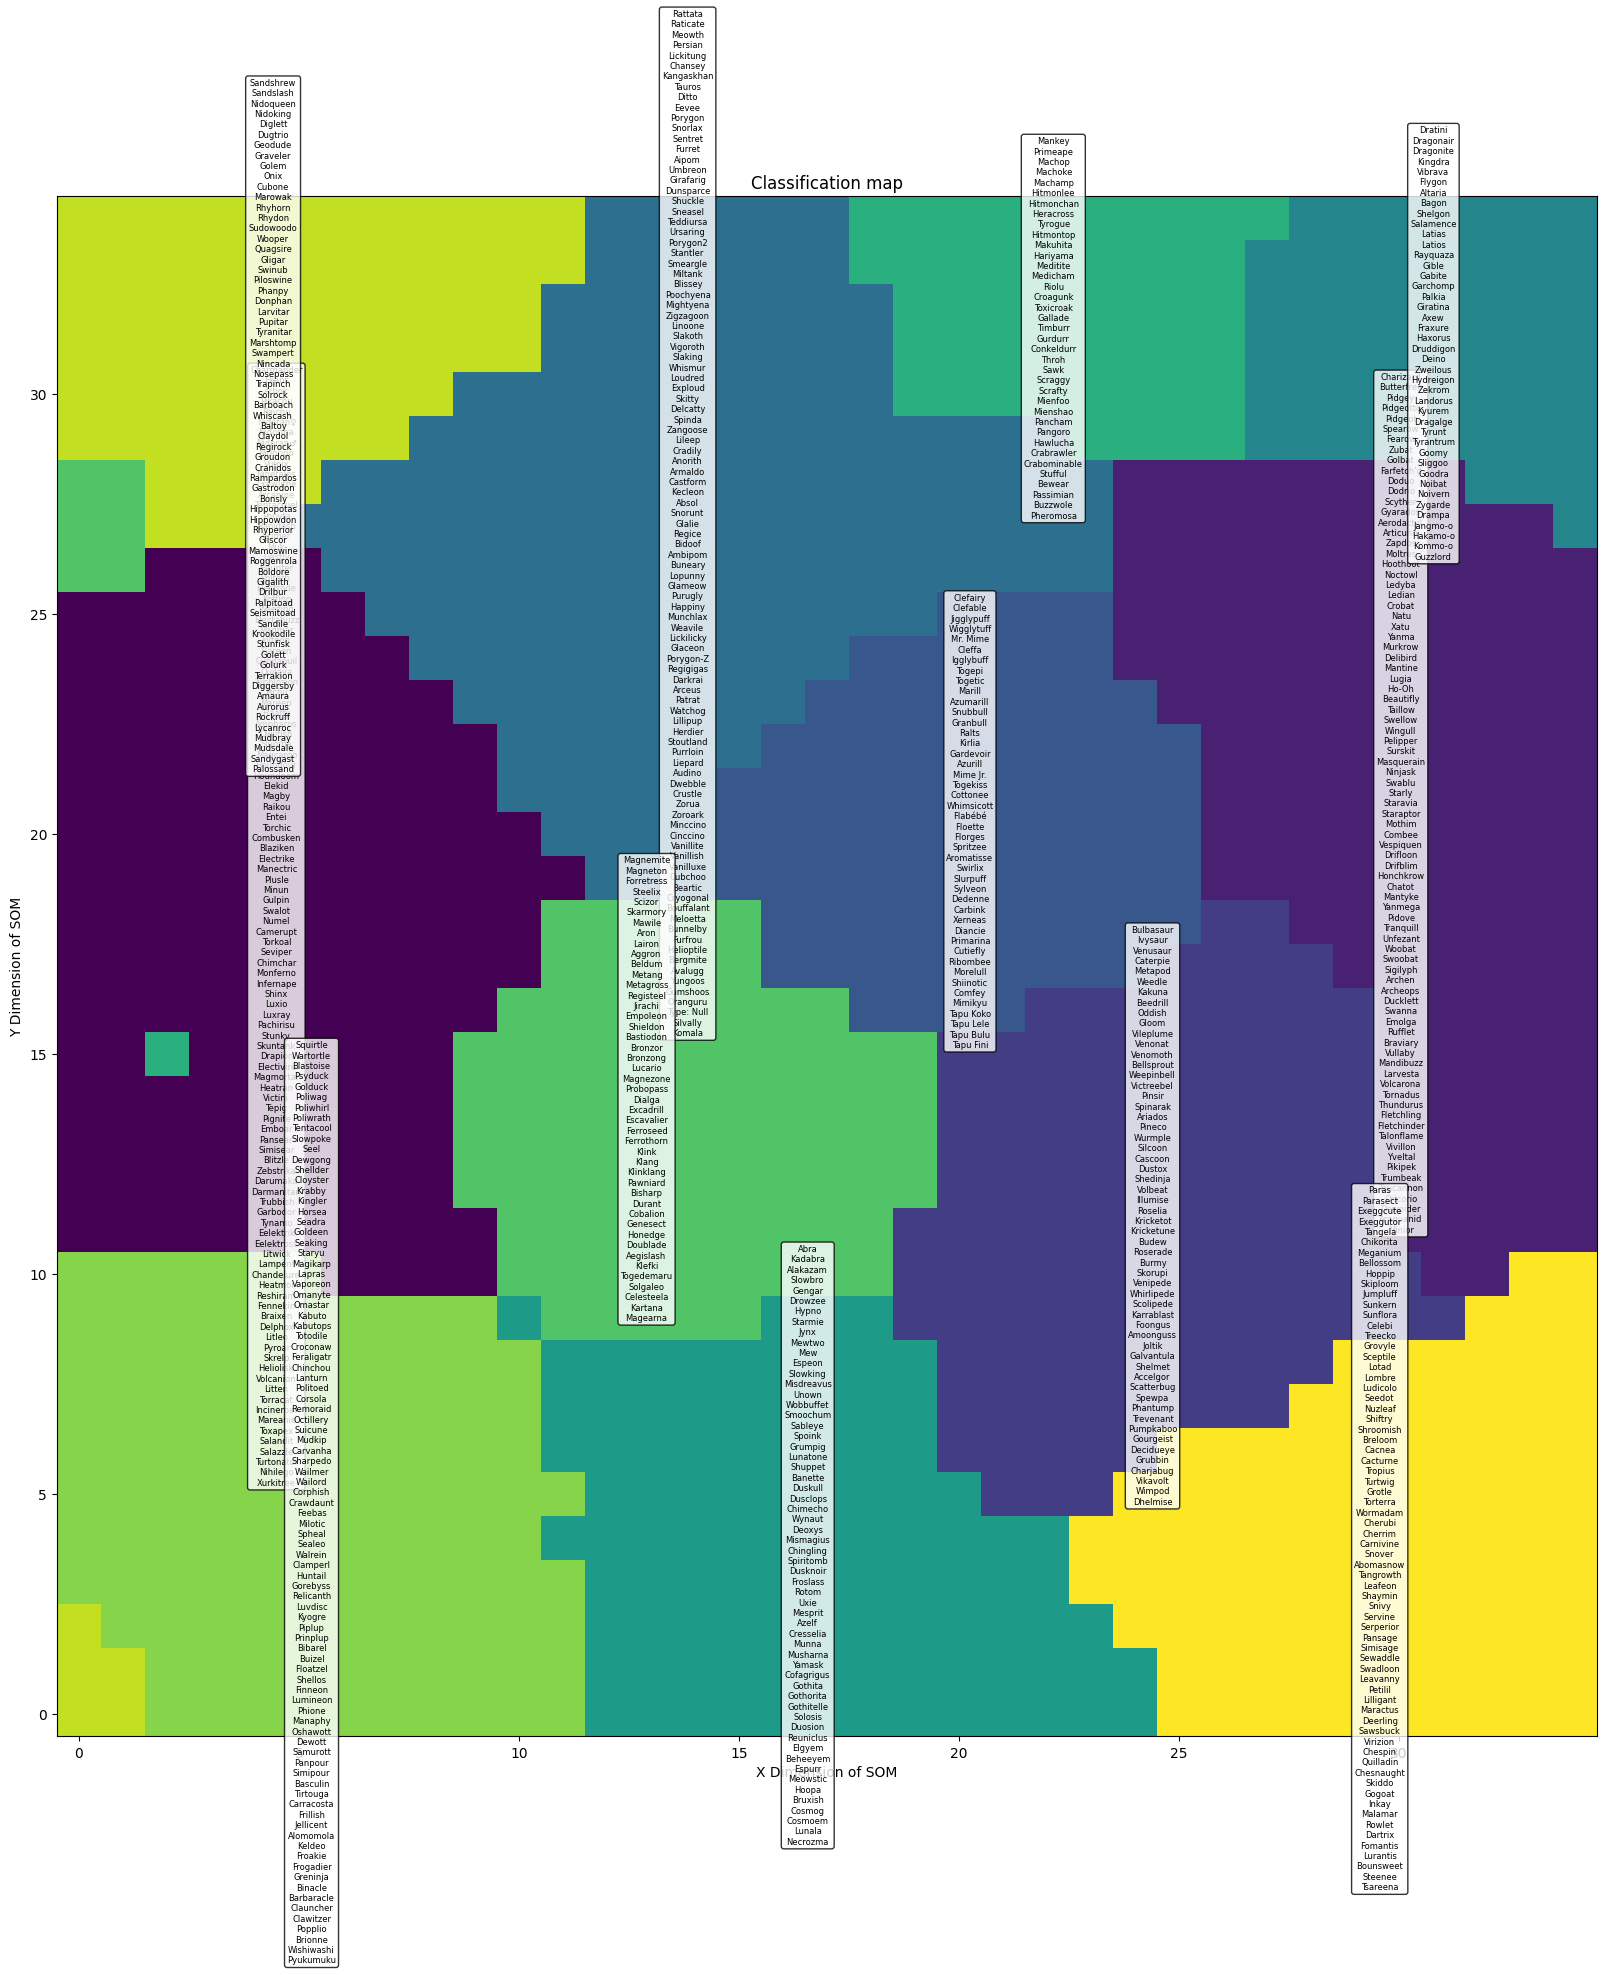

Cluster 0: Charmander, Ekans, Arbok, Pikachu, Raichu, Nidoran♀, Nidorina, Nidoran♂, Nidorino, Vulpix, Ninetales, Growlithe, Arcanine, Tentacruel, Ponyta, Rapidash, Grimer, Muk, Gastly, Haunter, Voltorb, Electrode, Koffing, Weezing, Electabuzz, Magmar, Jolteon, Flareon, Cyndaquil, Quilava, Typhlosion, Pichu, Mareep, Flaaffy, Ampharos, Qwilfish, Slugma, Magcargo, Houndour, Houndoom, Elekid, Magby, Raikou, Entei, Torchic, Combusken, Blaziken, Electrike, Manectric, Plusle, Minun, Gulpin, Swalot, Numel, Camerupt, Torkoal, Seviper, Chimchar, Monferno, Infernape, Shinx, Luxio, Luxray, Pachirisu, Stunky, Skuntank, Drapion, Electivire, Magmortar, Heatran, Victini, Tepig, Pignite, Emboar, Pansear, Simisear, Blitzle, Zebstrika, Darumaka, Darmanitan, Trubbish, Garbodor, Tynamo, Eelektrik, Eelektross, Litwick, Lampent, Chandelure, Heatmor, Reshiram, Fennekin, Braixen, Delphox, Litleo, Pyroar, Skrelp, Heliolisk, Volcanion, Litten, Torracat, Incineroar, Mareanie, Toxapex, Salandit, Salazzle, Turtonat

In [ ]:
normalize_data, _, _, _ = process_data_and_initialize_weights(train_dataset.values, model_w_matrix.shape[0], normalize_data=True)
bmu_indices = calculate_bmu_indices(normalize_data, model_w_matrix, best_map_side)
pokemon_locations = create_pokemon_locations(pokemon_names, bmu_indices)

visualize_map_pokemons_neuron(model_w_matrix, pokemon_locations, optimal_k)
print_pokemons_cluster(model_w_matrix, pokemon_locations, optimal_k)

In [ ]:
"""
This function shows the SOM map with Pokemon's are grouped by their assigned neurons, rather than by clusters.
It helps to visually understand how Pokémon are distributed across the neurons.
"""
def visualize_classification_map(weight_matrix, pokemon_locations, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(weight_matrix.reshape(-1, weight_matrix.shape[-1]))
    cluster_labels = cluster_labels.reshape(weight_matrix.shape[:2])
    cmap = plt.get_cmap('viridis', num_clusters)
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(cluster_labels, cmap=cmap, origin='lower')
    neuron_pokemon = defaultdict(list)
    for pokemon_name, loc in pokemon_locations.items():
        neuron_pokemon[tuple(loc)].append(pokemon_name)

    for loc, pokemon_names in neuron_pokemon.items():
        text = "\n".join(pokemon_names)
        bbox_props = dict(boxstyle="round", facecolor="white", alpha=0.8)
        ax.text(loc[1], loc[0], text, ha="center", va="center", bbox=bbox_props, fontsize=6)

    ax.set_title('Classification map')
    ax.set_xlabel('X Dimension of SOM')
    ax.set_ylabel('Y Dimension of SOM')
    plt.show()

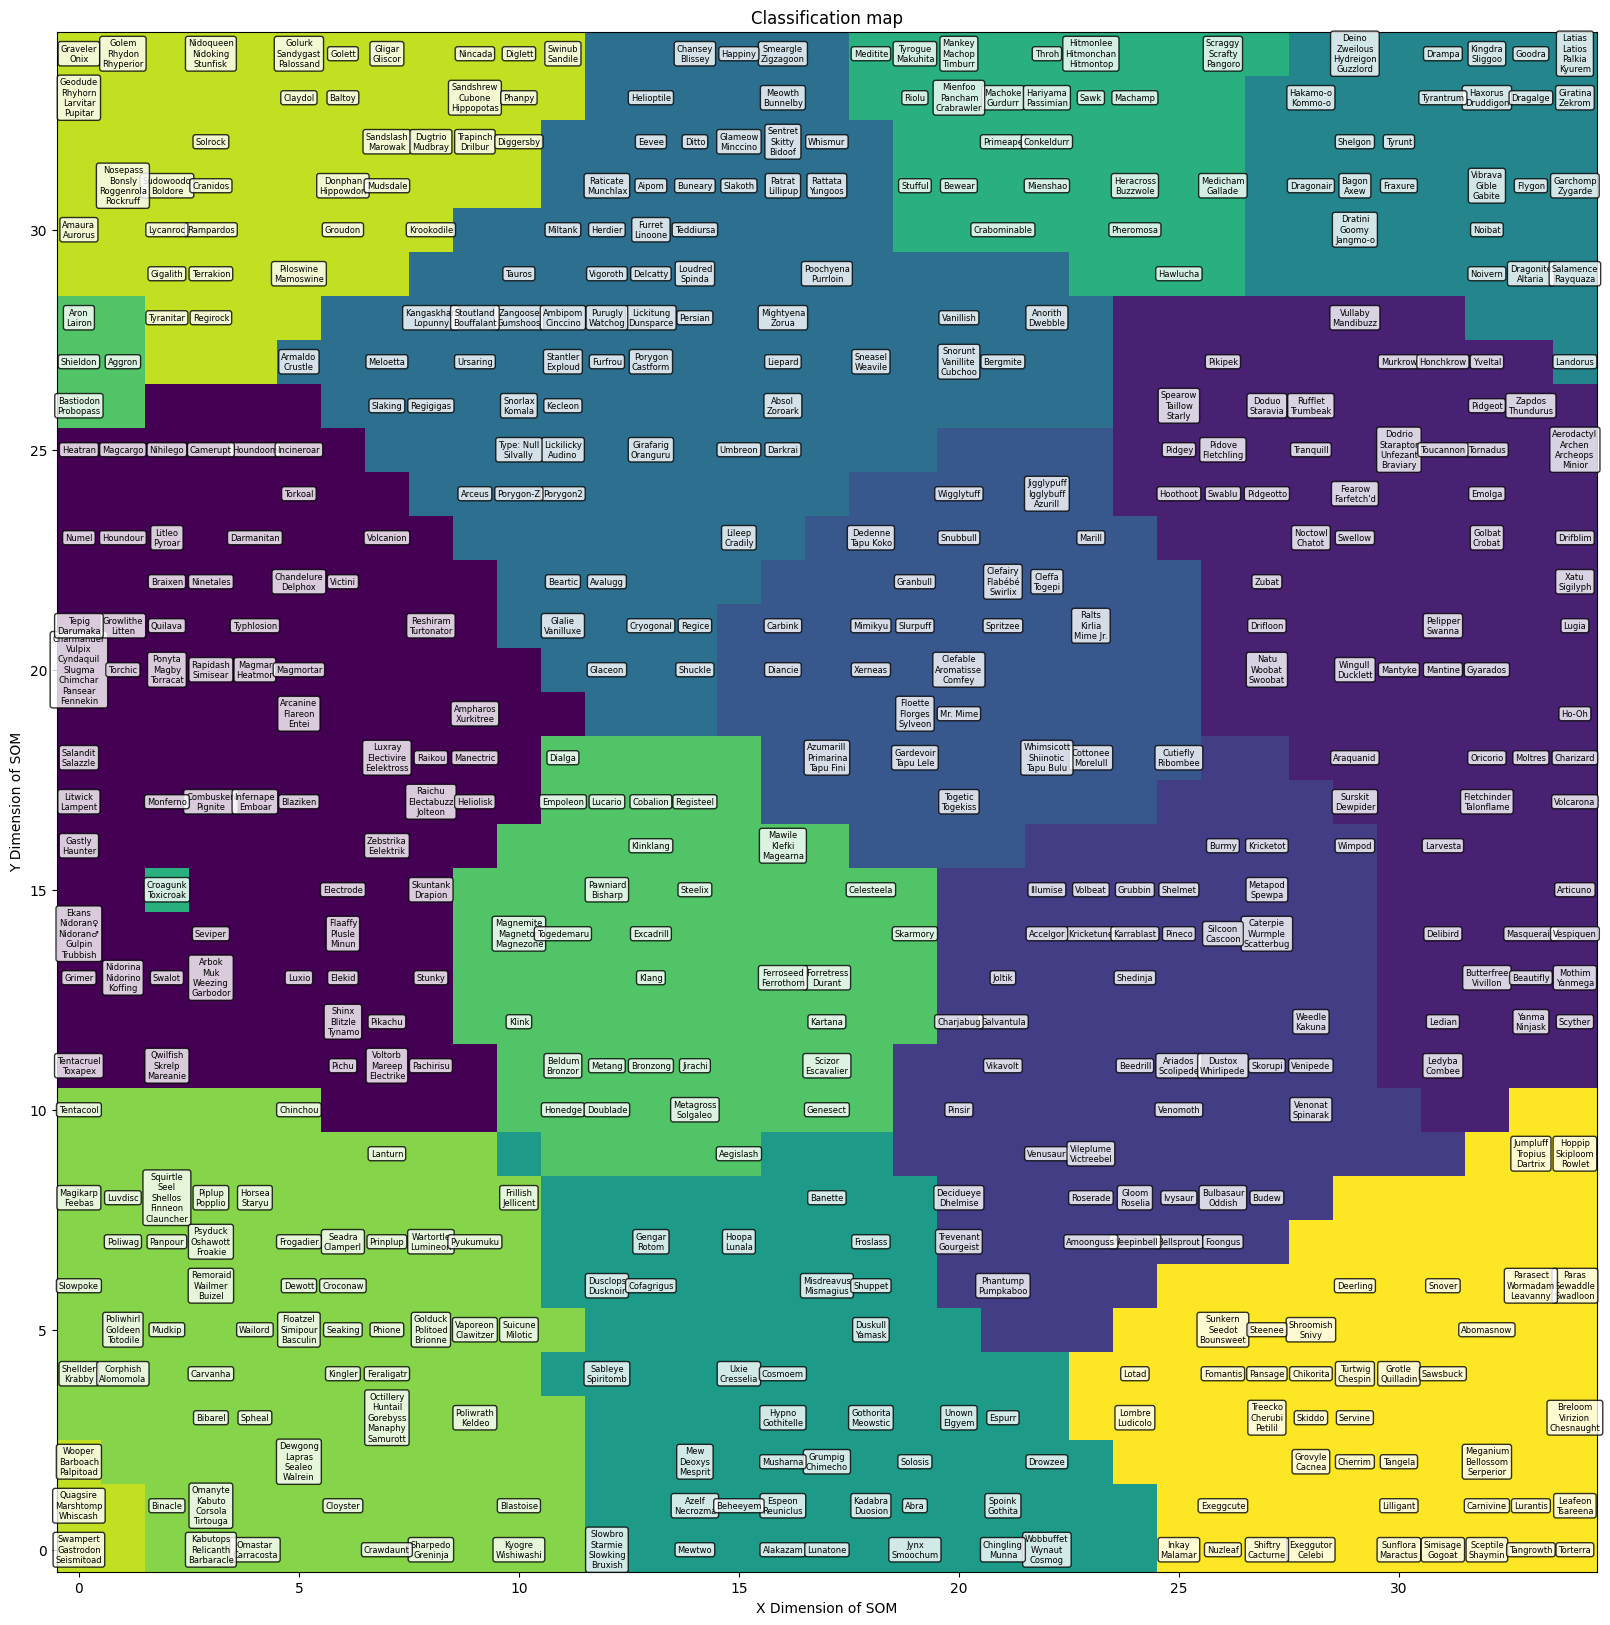

In [ ]:
visualize_classification_map(model_w_matrix, pokemon_locations, optimal_k)

##Activation map (3D histogram)

In [ ]:
map_size = model_w_matrix.shape[0]
num_features = model_w_matrix.shape[1]

weight_matrix_2d = model_w_matrix[:, :, 0].reshape(map_size, map_size)

# We create the 3D histogram
fig = go.Figure(data=[go.Surface(z=weight_matrix_2d)])
fig.update_layout(title="Activation Map (3D Histogram)",
                  scene=dict(xaxis_title="X",
                             yaxis_title="Y",
                             zaxis_title="Weight"),
                  autosize=False,
                  width=800,
                  height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
                 )

fig.show()

##Distance map of the dataset

In [ ]:
""" We calculate and visualize the average distance between each neuron and its neighbors. """

map_side = model_w_matrix.shape[0]
distance_map = np.zeros((map_side, map_side))

for i in range(map_side):
    for j in range(map_side):
        current_neuron_weight = model_w_matrix[i, j]

        neighbors = []
        for x in range(max(0, i - 1), min(map_side, i + 2)):
            for y in range(max(0, j - 1), min(map_side, j + 2)):
                if (x, y) != (i, j):
                    neighbors.append(model_w_matrix[x, y])

        if neighbors:
            distances = [np.linalg.norm(current_neuron_weight - neighbor) for neighbor in neighbors]
            distance_map[i, j] = np.mean(distances)

fig = px.imshow(distance_map,
                color_continuous_scale="RdYlBu",
                origin='lower',
                title="Distance Map Visualization")
fig.show()

##Quantification error and topographic error

In [ ]:
print(f"Hyperparameters: map_side={map_side}, epochs={epochs}, initial_lr={initial_lr}")

quantization_err = quantization_error(model_w_matrix, normalize_data, best_map_side)
print(f"Quantization Error: {quantization_err:.4f}")

topographic_err = topographic_error(model_w_matrix, normalize_data, best_map_side)
print(f"Topographic Error: {topographic_err:.4f}")

Hyperparameters: map_side=35, epochs=60000, initial_lr=0.05
Quantization Error: 0.2654
Topographic Error: 0.0879


# **Evaluation questions**

##In which cluster is Pikachu classified?


In [ ]:
""" Here, we visualize the classification map with clusters and highlight the cluster containing PIKACHU"""

def visualize_classification_map(weight_matrix, pokemon_locations, num_clusters, highlight_pokemon):

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(weight_matrix.reshape(-1, weight_matrix.shape[-1]))
    cluster_labels = cluster_labels.reshape(weight_matrix.shape[:2])

    cmap = plt.get_cmap('viridis', num_clusters)

    fig, ax = plt.subplots(figsize=(20, 20))

    ax.imshow(cluster_labels, cmap=cmap, origin='lower')

    cluster_pokemon = defaultdict(list)
    for pokemon_name, loc in pokemon_locations.items():
        cluster_id = cluster_labels[loc[0], loc[1]]
        cluster_pokemon[cluster_id].append(pokemon_name)

    highlight_cluster = None
    for cluster_id, pokemon_names in cluster_pokemon.items():
        if highlight_pokemon in pokemon_names:
            highlight_cluster = cluster_id
            break

    for cluster_id, pokemon_names in cluster_pokemon.items():
        cluster_indices = np.where(cluster_labels == cluster_id)
        center_x = np.mean(cluster_indices[1])
        center_y = np.mean(cluster_indices[0])
        text = "\n".join(pokemon_names)
        bbox_props = dict(boxstyle="round", facecolor="white" if cluster_id != highlight_cluster else "yellow", alpha=0.8)
        ax.text(center_x, center_y, text, ha="center", va="center", bbox=bbox_props, fontsize=6)

    ax.set_title('Classification map')
    ax.set_xlabel('X Dimension of SOM')
    ax.set_ylabel('Y Dimension of SOM')

    plt.show()

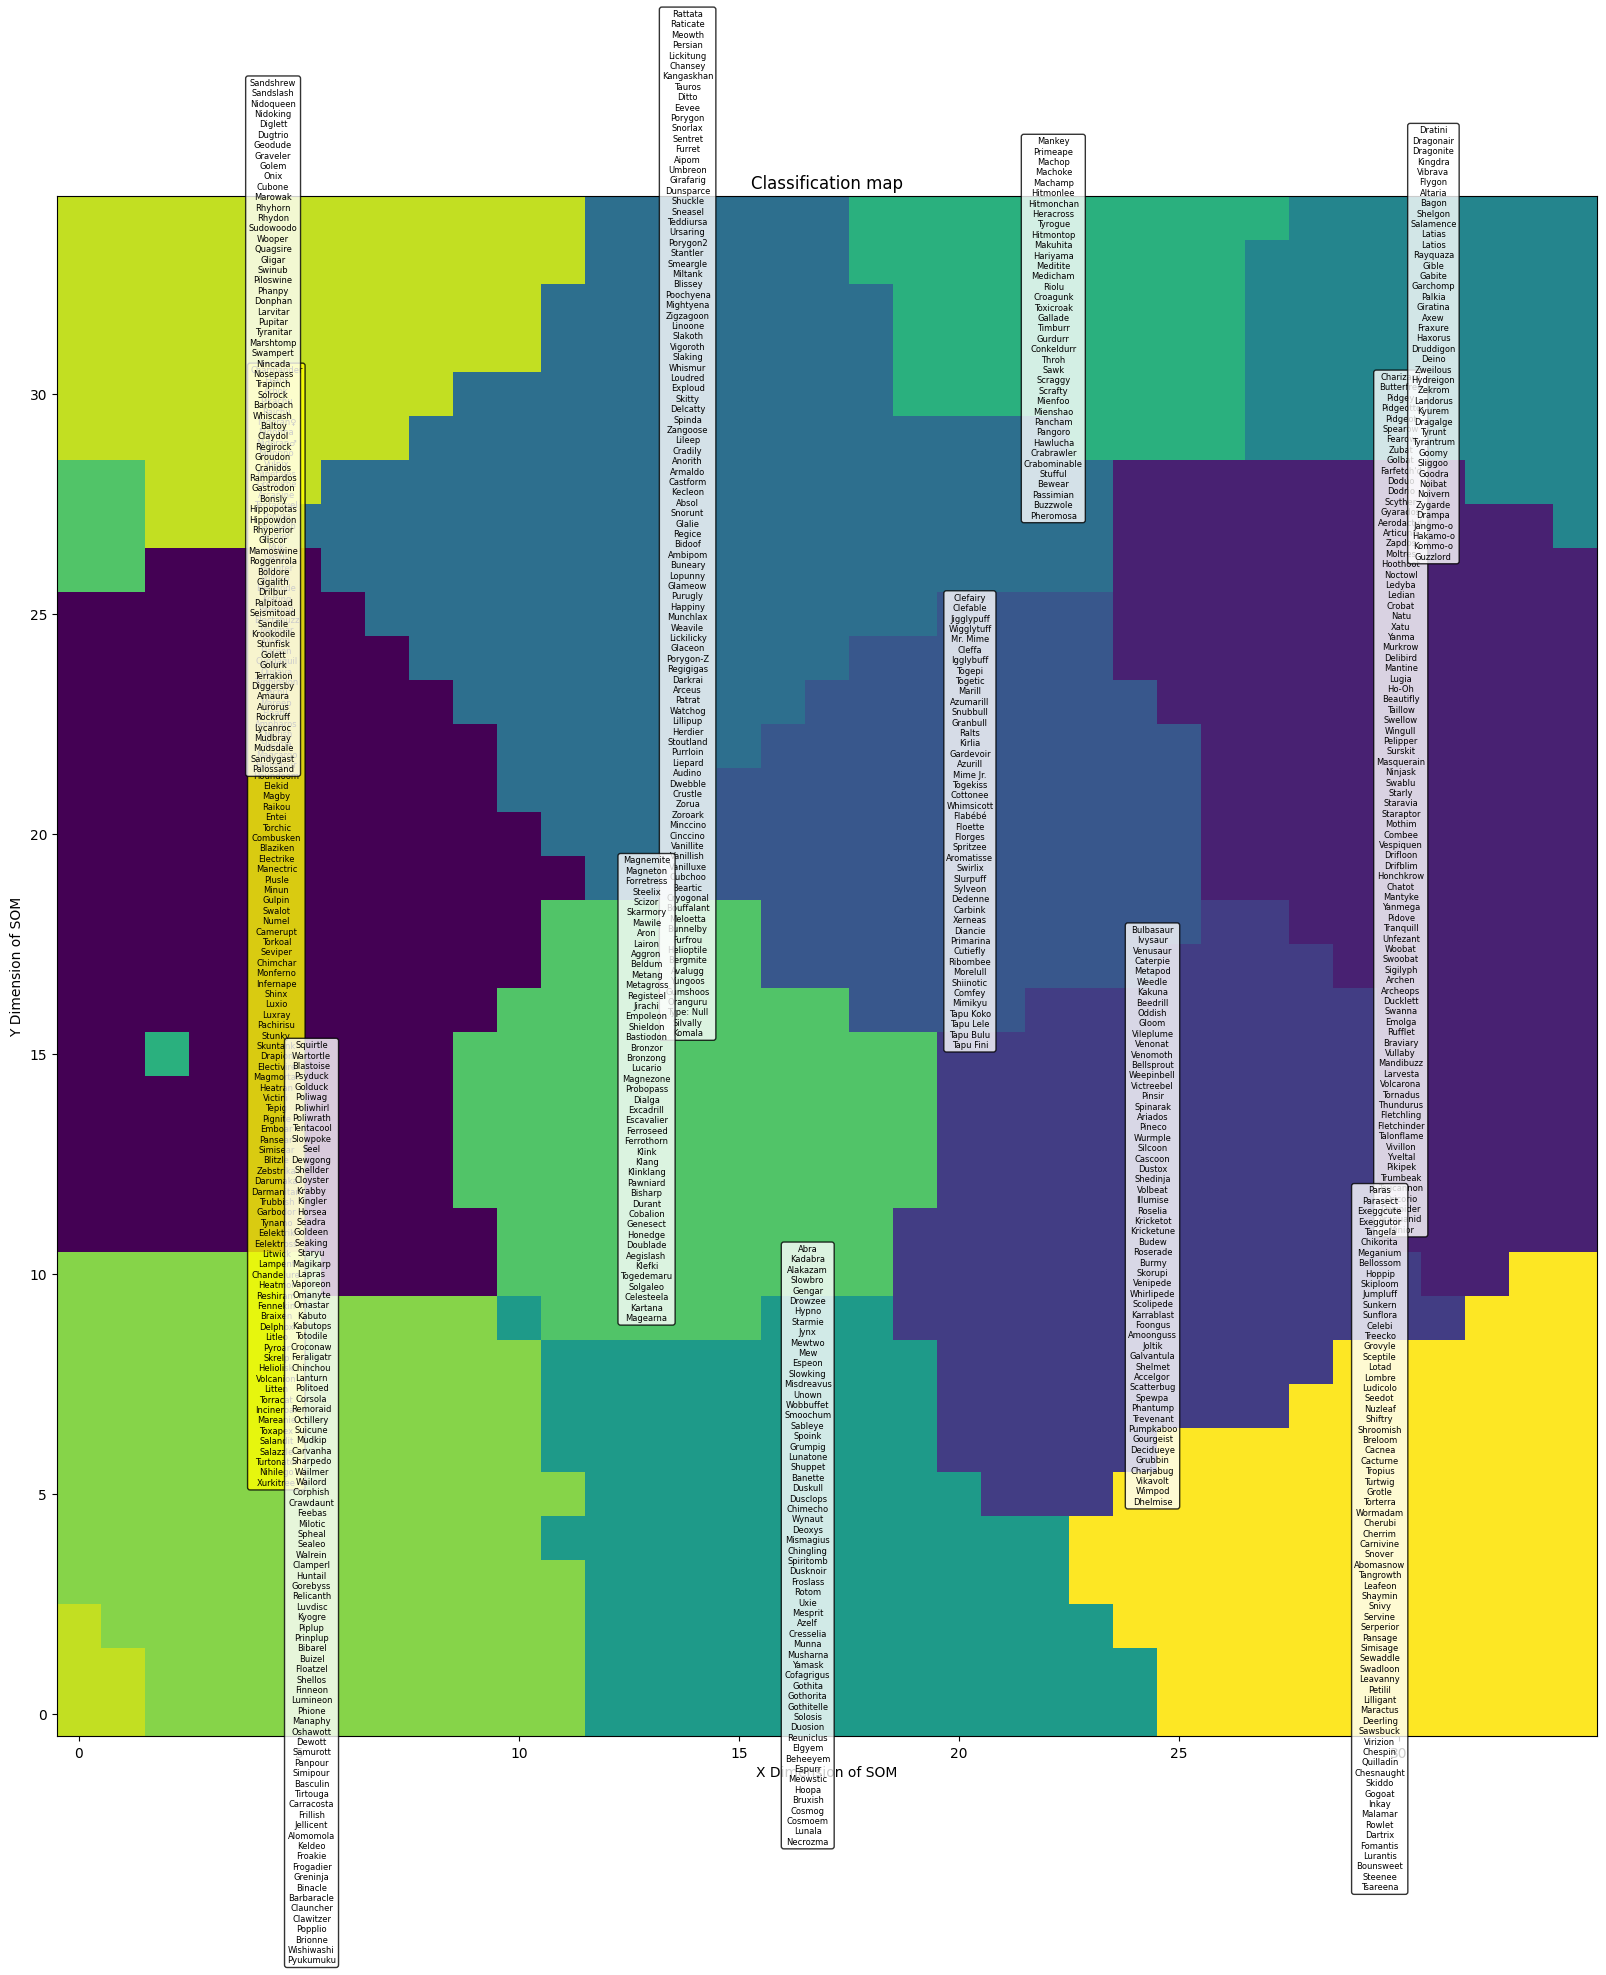

In [ ]:
visualize_classification_map(model_w_matrix, pokemon_locations, optimal_k, highlight_pokemon='Pikachu')

##Which are the features of the groups around the group in which Pikachu is classified?

In [ ]:
num_clusters = optimal_k
kmeans = KMeans(n_clusters=num_clusters, random_state=0)


reshaped_weights = model_w_matrix.reshape(-1, model_w_matrix.shape[-1])


kmeans.fit(reshaped_weights)

pikachu_data = train_dataset[pokemon_labels_train['name'] == 'Pikachu']


pikachu_cluster = kmeans.predict(pikachu_data)[0]

cluster_centers = kmeans.cluster_centers_

# Function to get neighbour clusters
def get_neighboring_clusters(cluster_labels, target_cluster, map_side):
    neighbors = []
    for i in range(map_side):
        for j in range(map_side):
            if cluster_labels[i, j] == target_cluster:
                for x in range(max(0, i - 1), min(map_side, i + 2)):
                    for y in range(max(0, j - 1), min(map_side, j + 2)):
                        if (x, y) != (i, j) and cluster_labels[x, y] != target_cluster:
                            neighbors.append(cluster_labels[x, y])
    return list(set(neighbors))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but KMeans was fitted without feature names



In [ ]:
# Get cluster labels
cluster_labels = kmeans.labels_.reshape(model_w_matrix.shape[:2])

# Get neighboring clusters next to pikachus
neighboring_clusters = get_neighboring_clusters(cluster_labels, pikachu_cluster, model_w_matrix.shape[0])


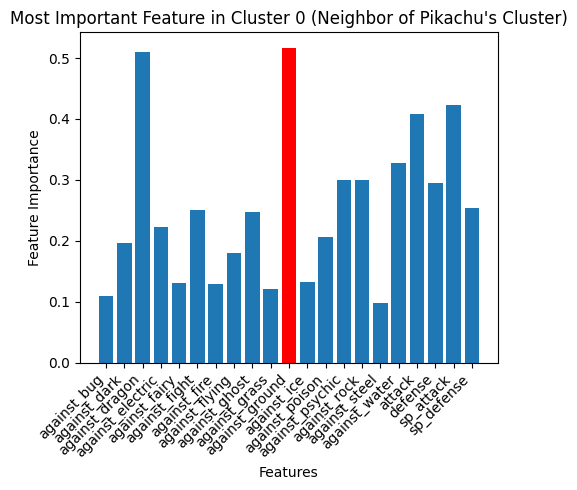

The most important feature in cluster 0 is: against_ground


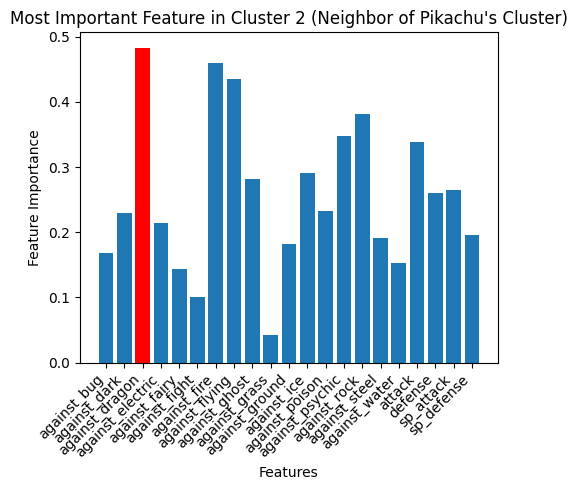

The most important feature in cluster 2 is: against_dragon


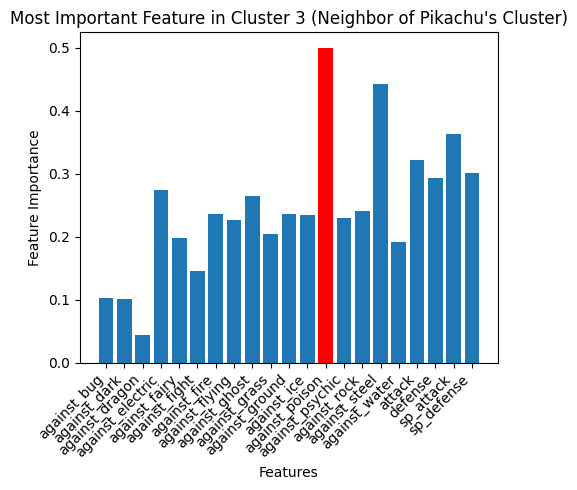

The most important feature in cluster 3 is: against_poison


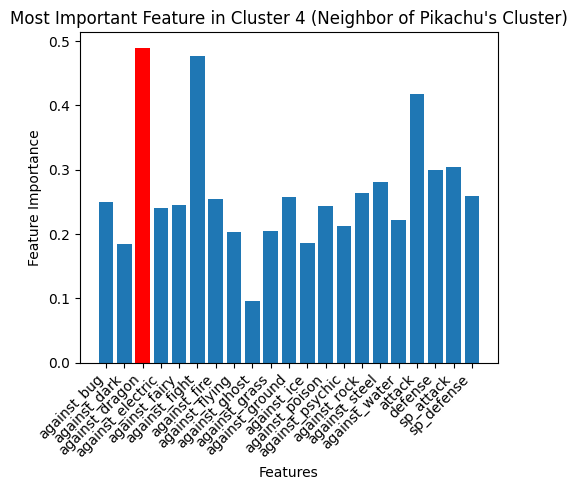

The most important feature in cluster 4 is: against_dragon


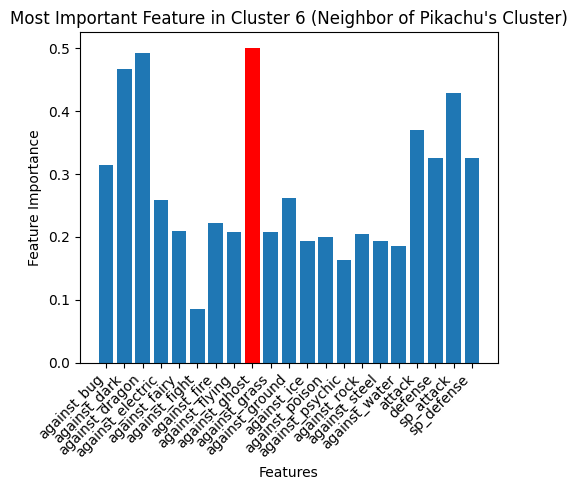

The most important feature in cluster 6 is: against_ghost


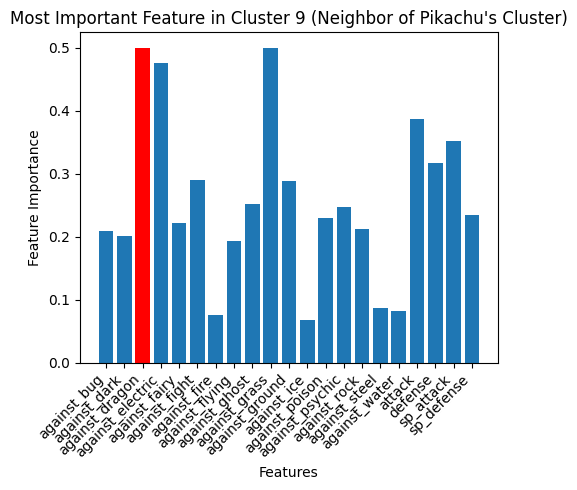

The most important feature in cluster 9 is: against_dragon


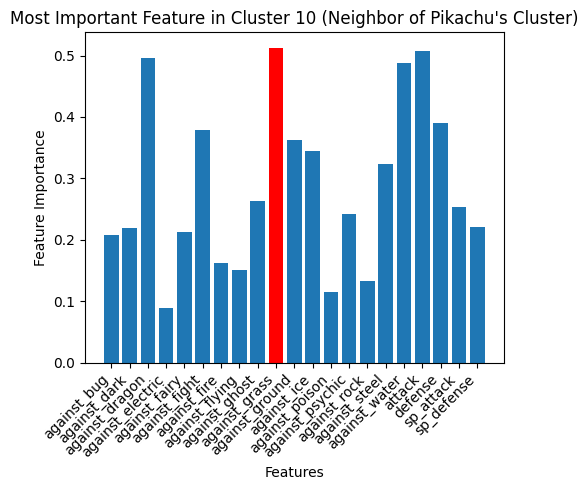

The most important feature in cluster 10 is: against_grass


In [ ]:
# Go through neighbour clusters and find most important features
for cluster in neighboring_clusters:
    cluster_center = cluster_centers[cluster]
    cluster_center = cluster_center[:len(train_dataset.columns)]
    most_important_feature_index = np.argmax(cluster_center)
    most_important_feature_name = train_dataset.columns[most_important_feature_index]

    # Plot feature importance for current cluster
    plt.figure(figsize=(5, 5))
    plt.bar(train_dataset.columns, cluster_center)
    plt.title(f"Most Important Feature in Cluster {cluster} (Neighbor of Pikachu's Cluster)")
    plt.xlabel("Features")
    plt.ylabel("Feature Importance")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.bar(most_important_feature_name, cluster_center[most_important_feature_index], color='red')

    plt.show()
    print(f"The most important feature in cluster {cluster} is: {most_important_feature_name}")

##Are Articuno and Moltres grouped together?

In [ ]:
pokemon1 = "Articuno"
pokemon2 = "Moltres"
loc1 = pokemon_locations[pokemon1]
loc2 = pokemon_locations[pokemon2]
fig = go.Figure()


z_values = model_w_matrix.mean(axis=2)

fig.add_trace(go.Heatmap(
    z=z_values,
    colorscale="Viridis"
))

fig.add_trace(go.Scatter(
    x=[loc1[1]], y=[loc1[0]],
    mode='markers+text',
    marker=dict(size=10, color="red"),
    text=[pokemon1],
    textposition="top center"
))

fig.add_trace(go.Scatter(
    x=[loc2[1]], y=[loc2[0]],
    mode='markers+text',
    marker=dict(size=10, color="blue"),
    text=[pokemon2],
    textposition="top center"
))

fig.update_layout(
    title=f'Location of {pokemon1} and {pokemon2} on the SOM (2D)',
    xaxis_title="X Dimension of SOM",
    yaxis_title="Y Dimension of SOM",
    xaxis=dict(scaleanchor="y")
)

fig.show()

In [ ]:
def print_pokemons_in_cluster_with(pokemon_name1, pokemon_name2, weight_matrix, pokemon_locations, num_clusters):
    """Prints the names of the Pokémon in the same cluster"""

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(weight_matrix.reshape(-1, weight_matrix.shape[-1]))
    cluster_labels = cluster_labels.reshape(weight_matrix.shape[:2])

    # Find the clusters of the given Pokémon
    pokemon_location1 = pokemon_locations[pokemon_name1]
    pokemon_cluster1 = cluster_labels[pokemon_location1[0], pokemon_location1[1]]
    pokemon_location2 = pokemon_locations[pokemon_name2]
    pokemon_cluster2 = cluster_labels[pokemon_location2[0], pokemon_location2[1]]

    # Check if both Pokémon are in the same cluster
    if pokemon_cluster1 == pokemon_cluster2:
        # Find all Pokémon in the same cluster
        pokemons_in_cluster = [pokemon for pokemon, location in pokemon_locations.items()
                           if cluster_labels[location[0], location[1]] == pokemon_cluster1]
        # Ensure the two input Pokémon are listed first
        pokemons_in_cluster.remove(pokemon_name1)
        pokemons_in_cluster.remove(pokemon_name2)
        pokemons_in_cluster = [pokemon_name1, pokemon_name2] + pokemons_in_cluster
        # Print the list of Pokémon in the cluster
        print("Pokemons in the cluster:")
        print("-------------------------")
        for pokemon in pokemons_in_cluster:
            print(pokemon)
    else:
        print(f"{pokemon_name1} and {pokemon_name2} are not in the same cluster.")

In [ ]:
print_pokemons_in_cluster_with("Articuno", "Moltres", model_w_matrix, pokemon_locations, optimal_k)

Pokemons in the cluster:
-------------------------
Articuno
Moltres
Charizard
Butterfree
Pidgey
Pidgeotto
Pidgeot
Spearow
Fearow
Zubat
Golbat
Farfetch'd
Doduo
Dodrio
Scyther
Gyarados
Aerodactyl
Zapdos
Hoothoot
Noctowl
Ledyba
Ledian
Crobat
Natu
Xatu
Yanma
Murkrow
Delibird
Mantine
Lugia
Ho-Oh
Beautifly
Taillow
Swellow
Wingull
Pelipper
Surskit
Masquerain
Ninjask
Swablu
Starly
Staravia
Staraptor
Mothim
Combee
Vespiquen
Drifloon
Drifblim
Honchkrow
Chatot
Mantyke
Yanmega
Pidove
Tranquill
Unfezant
Woobat
Swoobat
Sigilyph
Archen
Archeops
Ducklett
Swanna
Emolga
Rufflet
Braviary
Vullaby
Mandibuzz
Larvesta
Volcarona
Tornadus
Thundurus
Fletchling
Fletchinder
Talonflame
Vivillon
Yveltal
Pikipek
Trumbeak
Toucannon
Oricorio
Dewpider
Araquanid
Minior


##What significance would you attribute to the cluster in which Slowbro is placed?

In [ ]:
slowbro_location = pokemon_locations['Slowbro']

cluster_map = result[0].reshape(model_w_matrix.shape[:2])

slowbro_cluster = cluster_map[slowbro_location[0], slowbro_location[1]]
pokemons_in_cluster = [pokemon_name for pokemon_name, location in pokemon_locations.items()
                       if cluster_map[location[0], location[1]] == slowbro_cluster]



print(f"Slowbro is in cluster {slowbro_cluster}")
print("-" * 26)
print("Pokemons in the same cluster:")
for pokemon_name in pokemons_in_cluster:
    if pokemon_name != 'Slowbro':
        print(pokemon_name)

Slowbro is in cluster 1
--------------------------
Pokemons in the same cluster:
Abra
Kadabra
Alakazam
Gengar
Drowzee
Hypno
Starmie
Jynx
Mewtwo
Mew
Espeon
Slowking
Misdreavus
Unown
Wobbuffet
Smoochum
Sableye
Spoink
Grumpig
Lunatone
Shuppet
Banette
Duskull
Dusclops
Chimecho
Wynaut
Deoxys
Mismagius
Chingling
Spiritomb
Dusknoir
Froslass
Rotom
Uxie
Mesprit
Azelf
Cresselia
Munna
Musharna
Yamask
Cofagrigus
Gothita
Gothorita
Gothitelle
Solosis
Duosion
Reuniclus
Elgyem
Beheeyem
Espurr
Meowstic
Hoopa
Bruxish
Cosmog
Cosmoem
Lunala
Necrozma


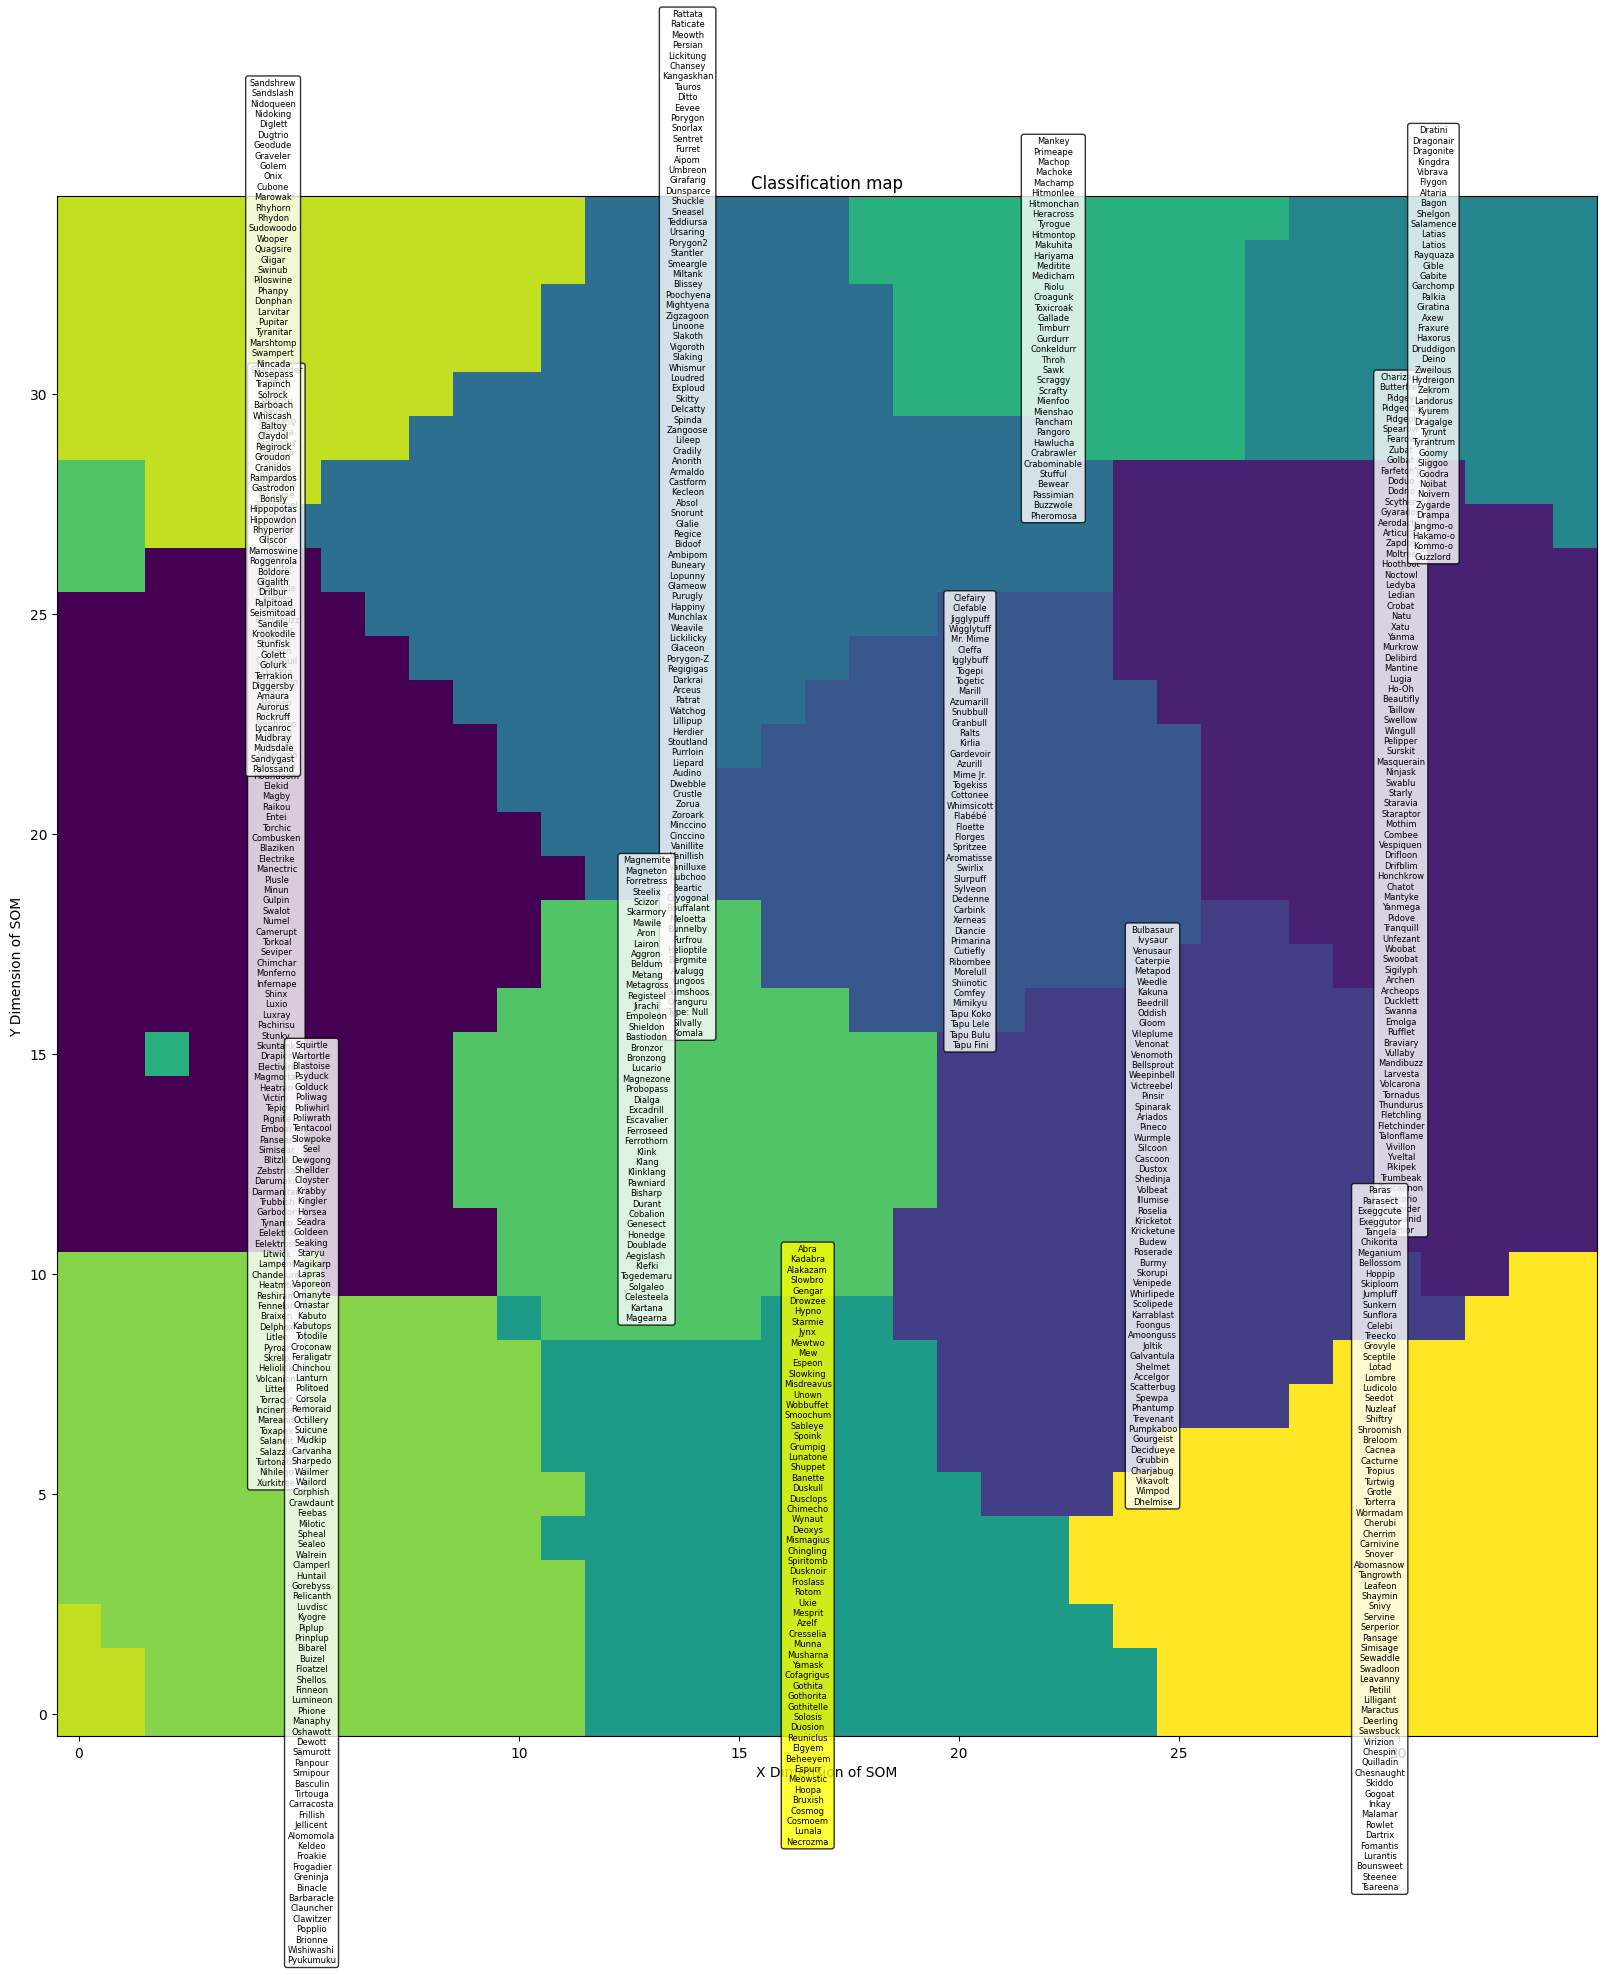

In [ ]:
visualize_classification_map(model_w_matrix, pokemon_locations, optimal_k, highlight_pokemon='Slowbro')